In [20]:
import equinox as eqx
from neuralodes.model.oderesnet.odenet import ODENet, ODENetEulerWrapper
from neuralodes.model.oderesnet.resnet import ResNet
#from neuralodes.model.oderesnet.utils.ode_modules import ODEBlockEulerWrapper
from neuralodes.data.dataloader import get_dataloaders
from neuralodes.model.oderesnet.evaluation import evaluate
from pathlib import Path
import os
import jax.random as jrandom
import numpy as np
from neuralodes.model.oderesnet.loss import loss


In [2]:
if Path(os.getcwd()).name == "notebooks":
    os.chdir(Path(os.getcwd()).parent)

In [41]:
key = jrandom.PRNGKey(0)
model_solver_name = "tsit5"
loaded_solver_name = 'Tsit5'

odenet = eqx.tree_deserialise_leaves(Path("models", "oderesnet", f"odenet_fashionmnist_{loaded_solver_name}_64.eqx"), ODENet(key, model_solver_name))
resnet = eqx.tree_deserialise_leaves(Path("models", "oderesnet", f"resnet_fashionmnist_Tsit5_64.eqx"), ResNet(key))

In [42]:
_, test_dataloader = get_dataloaders("fashionmnist", 256)

In [51]:
losses_euler = []
accs_euler = []
max_steps = 20
from tqdm import tqdm
steps_arr = list(range(1, max_steps+1))

for steps in tqdm(range(1,max_steps+1)):
    odenet_euler = ODENetEulerWrapper(odenet, steps)
    loss, acc = evaluate(odenet_euler, test_dataloader)
    losses_euler.append(loss)
    accs_euler.append(acc)

100%|██████████| 20/20 [00:35<00:00,  1.75s/it]


### Tsit5

In [48]:
loss_baseline_ode, acc_baseline_ode = evaluate(odenet, test_dataloader)
loss_baseline_res, acc_baseline_res = evaluate(resnet, test_dataloader)

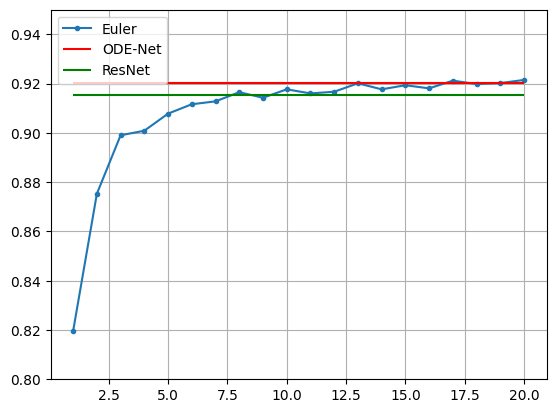

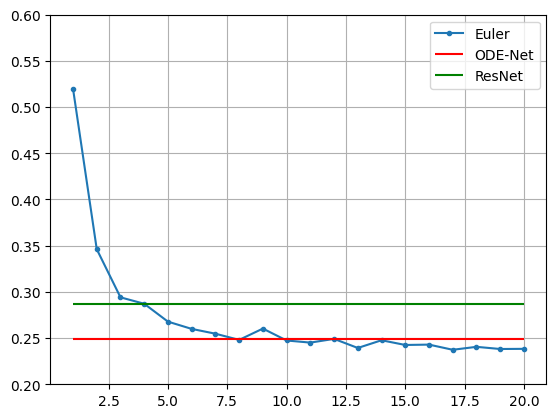

In [58]:
from matplotlib import pyplot as plt
plt.plot(steps_arr, accs_euler, '.-')
plt.hlines(acc_baseline_ode, 1, max_steps, 'red')
plt.hlines(acc_baseline_res, 1, max_steps, 'green')
plt.legend(["Euler","ODE-Net", "ResNet"])
plt.ylim([0.8, 0.95])
plt.grid()
plt.show()

plt.plot(steps_arr, losses_euler, '.-')
plt.hlines(loss_baseline_ode, 1, max_steps, 'red')
plt.hlines(loss_baseline_res, 1, max_steps, 'green')
plt.legend(["Euler","ODE-Net", "ResNet"])
plt.ylim([0.2, 0.6])
plt.grid()
plt.show()

### Bosh3

In [38]:
loss_baseline_ode, acc_baseline_ode = evaluate(odenet, test_dataloader)
loss_baseline_res, acc_baseline_res = evaluate(resnet, test_dataloader)

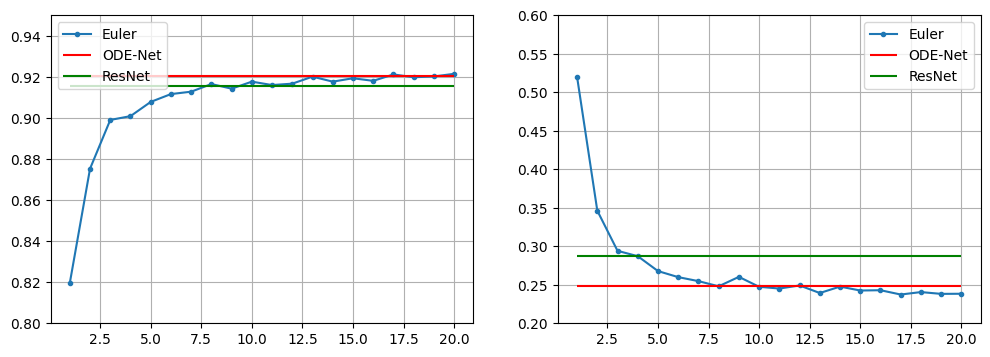

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy on the left subplot (ax1)
ax1.plot(steps_arr, accs_euler, '.-')
ax1.hlines(acc_baseline_ode, 1, max_steps, 'red')
ax1.hlines(acc_baseline_res, 1, max_steps, 'green')
ax1.legend(["Euler", "ODE-Net", "ResNet"])
ax1.set_ylim([0.8, 0.95])
ax1.grid()


# Plot loss on the right subplot (ax2)
ax2.plot(steps_arr, losses_euler, '.-')
ax2.hlines(loss_baseline_ode, 1, max_steps, 'red')
ax2.hlines(loss_baseline_res, 1, max_steps, 'green')
ax2.legend(["Euler", "ODE-Net", "ResNet"])
ax2.set_ylim([0.2, 0.6])
ax2.grid()

# Display the plots
fig.savefig("test.png", dpi=300)
plt.show()

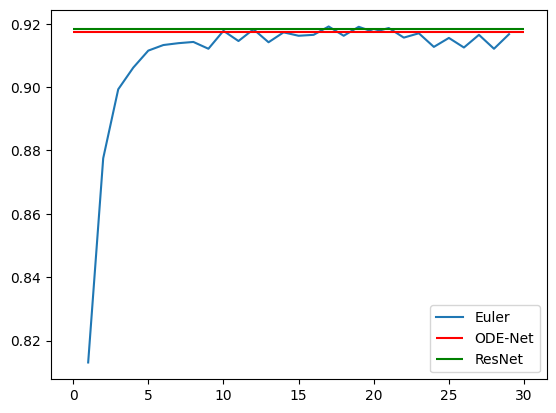

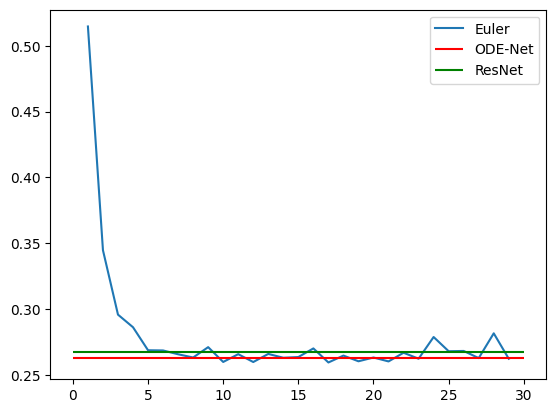

In [39]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plt.plot(steps_arr, accs_euler)
plt.hlines(acc_baseline_ode, 0, max_steps, 'red')
plt.hlines(acc_baseline_res, 0, max_steps, 'green')
plt.legend(["Euler","ODE-Net", "ResNet"])
plt.show()
plt.plot(steps_arr, losses_euler)

plt.hlines(loss_baseline_ode, 0, max_steps, 'red')
plt.hlines(loss_baseline_res, 0, max_steps, 'green')
plt.legend(["Euler","ODE-Net", "ResNet"])
plt.show()

### Dopri3

In [ ]:
loss_baseline_ode, acc_baseline_ode = evaluate(odenet, test_dataloader)
loss_baseline_res, acc_baseline_res = evaluate(resnet, test_dataloader)

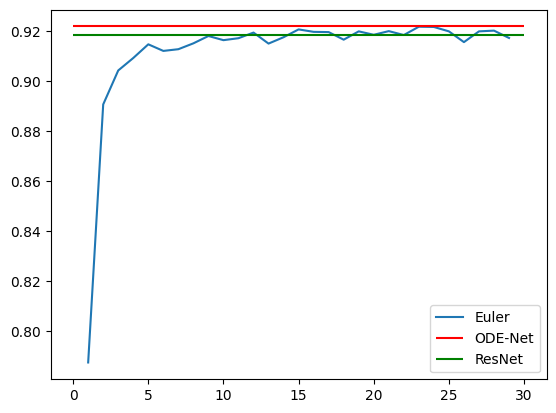

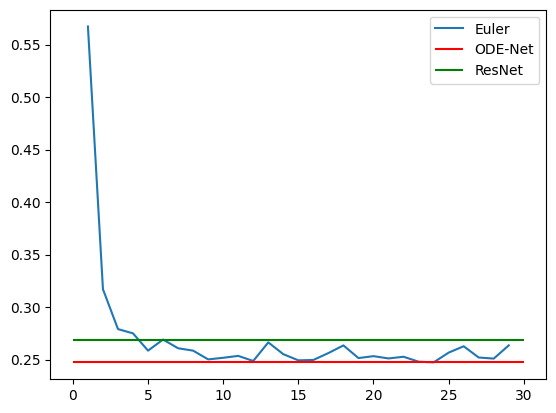

In [34]:
from matplotlib import pyplot as plt
plt.plot(steps_arr, accs_euler)
plt.hlines(acc_baseline_ode, 0, max_steps, 'red')
plt.hlines(acc_baseline_res, 0, max_steps, 'green')
plt.legend(["Euler","ODE-Net", "ResNet"])
plt.show()
plt.plot(steps_arr, losses_euler)

plt.hlines(loss_baseline_ode, 0, max_steps, 'red')
plt.hlines(loss_baseline_res, 0, max_steps, 'green')
plt.legend(["Euler","ODE-Net", "ResNet"])
plt.show()

In [87]:
from matplotlib import pyplot as plt
import jax.numpy as jnp

t_values = [0,1]
ode_func = odenet.layers[1].odefunc

# Define a function to visualize the sensitivity
def visualize_sensitivity(sensitivity, t_values):
    num_t_values = len(t_values)
    num_channels = sensitivity.shape[1]
    
    fig, axes = plt.subplots(num_channels, num_t_values, figsize=(4 * num_t_values, 4 * num_channels))
    
    for i, t in enumerate(t_values):
        for j in range(num_channels):
            ax = axes[j, i]
            ax.imshow(sensitivity[i, j], cmap='viridis', aspect='auto')
            ax.axis('off')
            if j == 0:
                ax.set_title(f't = {t}')

    plt.tight_layout()
    plt.show()

# Generate a small perturbation to the input data (x)
epsilon = 1e-2
perturbation = epsilon * jrandom.normal(key, x.shape)
x_perturbed = x + perturbation

# Compute the output for the original and perturbed inputs
outputs = []
outputs_perturbed = []
for t in t_values:
    output = ode_func(t, x, None)
    output_perturbed = ode_func(t, x_perturbed, None)
    outputs.append(output[0])
    outputs_perturbed.append(output_perturbed[0])

outputs = jnp.stack(outputs)
outputs_perturbed = jnp.stack(outputs_perturbed)

# Calculate the difference between the outputs
sensitivity = jnp.abs(outputs_perturbed - outputs)

# Visualize the sensitivity
visualize_sensitivity(sensitivity, t_values)

ValueError: cannot reshape array of size 784 into shape (32,0,28,28)